# Capstone: Vital Statistics of Professional Athletes

## Analysis Notebook for pro hockey players

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

In [2]:
# Read in DataFrames
all_hockey_df = pd.read_csv('./all_hockey.csv')
deceased_hockey_df = pd.read_csv('./deceased_hockey.csv')

In [3]:
all_hockey_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7753 entries, 0 to 7752
Data columns (total 10 columns):
Unnamed: 0    7753 non-null int64
birth date    7753 non-null object
birth year    7753 non-null int64
death date    1294 non-null object
first year    7753 non-null int64
games         7752 non-null float64
last year     7753 non-null int64
link          7753 non-null object
name          7753 non-null object
position      7752 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 605.8+ KB


In [4]:
deceased_hockey_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293 entries, 0 to 1292
Data columns (total 11 columns):
Unnamed: 0      1293 non-null int64
age             1293 non-null int64
birth date      1293 non-null object
death date      1293 non-null object
death season    1293 non-null int64
first year      1293 non-null int64
games           1293 non-null int64
last year       1293 non-null int64
link            1293 non-null object
name            1293 non-null object
position        1293 non-null object
dtypes: int64(6), object(5)
memory usage: 111.2+ KB


In [5]:
# Why is there a hockey player with no games listed?
all_hockey_df[all_hockey_df['games'].isnull()]

,Unnamed: 0,birth date,birth year,death date,first year,games,last year,link,name,position
1183,1183,March 22,1932,NaN,1963,NaN,1963,/players/l/lucasda01.html,Dave Lucas,D


In [6]:
deceased_hockey_df['death year'] = [int(str(date)[:4]) for date in deceased_hockey_df['death date']]

### Merge hockey DataFrames

In [7]:
merged_hockey_df = pd.merge(all_hockey_df,
                            deceased_hockey_df[['link', 'death year', 'age']],
                            how='outer',
                            on='link')

In [8]:
merged_hockey_df.head()

,Unnamed: 0,birth date,birth year,death date,first year,games,last year,link,name,position,death year,age
0,0,July 17,1879,"January 9, 1960",1918,18.0,1918,/players/l/lavioja01.html,Jack Laviolette,LW,1960.0,80.0
1,1,May 3,1881,"April 5, 1919",1918,37.0,1919,/players/h/halljo01.html,Joe Hall,D,1919.0,37.0
2,2,July 23,1881,"November 11, 1960",1918,20.0,1919,/players/l/lindsbe01.html,Bert Lindsay,G,1960.0,79.0
3,3,May 29,1881,"November 25, 1933",1918,1.0,1918,/players/t/thompke01.html,Ken Thompson,F,1933.0,52.0
4,4,December 31,1883,"June 1, 1960",1927,1.0,1927,/players/p/patrile01.html,Lester Patrick,D,1960.0,76.0


### Group hockey players by when they were born and when they died

In [9]:
hockey_birth_count = merged_hockey_df.groupby('birth year').count()

hockey_death_count = merged_hockey_df.groupby('death year').count()

### Plot: Number of hockey players born/died in a given year

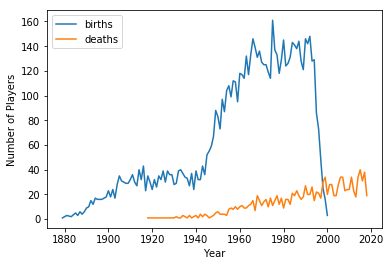

In [10]:
plt.plot(hockey_birth_count.index, hockey_birth_count['link'], label='births')
plt.plot(hockey_death_count.index, hockey_death_count['link'], label='deaths')
plt.xlabel('Year')
plt.ylabel('Number of Players')
plt.legend()

### Expected number of Deaths of Hockey Players

In [11]:
hockey_exp_deaths = {}
for year in range(2004, 2016):
    try:
        ssa = pd.read_csv('./ssa_tables/death_pct_' + str(year) + '.csv')
    except:
        continue
    total = 0
    for i in range(1, ssa.shape[0]):
        birth_year = year - i
        if birth_year in hockey_birth_count.index:
            total += ssa.loc[i, 'male death pct'] * hockey_birth_count.loc[birth_year, 'link']
    hockey_exp_deaths[year] = total

In [12]:
hockey_exp_deaths

{2004: 40.976320000000015,
 2005: 41.76285,
 2006: 42.41636,
 2007: 42.94315000000001,
 2009: 44.14754,
 2010: 44.71521000000001,
 2011: 45.59246,
 2013: 47.47454999999999,
 2014: 48.57716999999999,
 2015: 49.93737999999998}

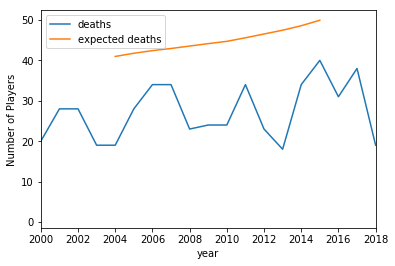

In [22]:
hockey_exp_deaths_df = pd.DataFrame.from_dict(hockey_exp_deaths, orient='index', columns=['exp deaths'])

plt.plot(hockey_death_count.index, hockey_death_count['link'], label='deaths')
plt.plot(hockey_exp_deaths_df, label='expected deaths')
plt.xlabel('year')
plt.ylabel('Number of Players')
plt.xlim(2000, 2018)
plt.legend()

### Compare Distributions of Ages at Death of NHL players in a given year versus that of the general population

In [13]:
us_live_births = pd.read_csv('./NCHS_-_Births_and_General_Fertility_Rates__United_States.csv')

us_live_births.set_index(['Year'], inplace=True)

In [14]:
for year in range(2004, 2016):
    try:
        death_pct = pd.read_csv('./ssa_tables/death_pct_' + str(year) + '.csv')
    except:
        continue
    us_est_deaths = [death_pct.loc[year-i+1, 'male death pct'] * us_live_births.loc[i, 'Birth Number'] 
                     for i in us_live_births.index if i <= year]
    probs = us_est_deaths[18:] / sum(us_est_deaths[18:])
    ages = len(us_est_deaths[18:])
    result = stats.ttest_ind(np.random.choice(range(18, 18+ages), 10000, replace=True, p=probs),
                             merged_hockey_df[merged_hockey_df['death year'] == year]['age'])
    print(year, result.pvalue)

2004 0.5397912554292141
2005 0.7418441348595533
2006 0.44293437680355074
2007 0.26738438311448387
2009 0.5840035043985884
2010 0.8877956877450088
2011 4.83947888186606e-12
2013 0.23814362015158372
2014 0.1201258701093913
2015 0.21572292042108518


### What percentage of hockey players born in a given year are still alive?

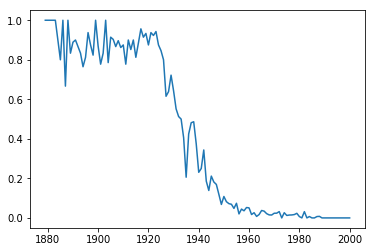

In [15]:
merged_hockey_df_counts = merged_hockey_df.groupby('birth year').count()

merged_hockey_df_counts.columns

merged_hockey_df_counts['pct deaths recorded'] = merged_hockey_df_counts['death year'] / merged_hockey_df_counts['link']

plt.plot(merged_hockey_df_counts['pct deaths recorded'])

In [16]:
hockey_birth_count.columns

Index(['Unnamed: 0', 'birth date', 'death date', 'first year', 'games',
       'last year', 'link', 'name', 'position', 'death year', 'age'],
      dtype='object')

In [17]:
merged_hockey_df_counts.loc[1920:1960, ['link','death year', 'pct deaths recorded']]

,link,death year,pct deaths recorded
birth year,,,
1920,24,21,0.875000
1921,32,30,0.937500
1922,26,24,0.923077
1923,35,33,0.942857
1924,32,28,0.875000
1925,39,33,0.846154
1926,30,24,0.800000
1927,39,24,0.615385
1928,36,23,0.638889


### Average age of hockey players who died in a given year
Note the sudden drop for the year 2011

In [18]:
merged_hockey_df.groupby('death year').mean()

,Unnamed: 0,birth year,first year,games,last year,age
death year,,,,,,
1918.0,12.000000,1886.000000,1918.000000,18.000000,1918.000000,32.000000
1919.0,1.000000,1881.000000,1918.000000,37.000000,1919.000000,37.000000
1924.0,34.000000,1890.000000,1918.000000,121.000000,1924.000000,33.000000
1926.0,19.000000,1887.000000,1918.000000,190.000000,1926.000000,39.000000
1929.0,272.000000,1904.000000,1926.000000,54.000000,1929.000000,25.000000
1930.0,177.000000,1900.000000,1920.000000,21.000000,1920.000000,29.000000
1931.0,263.000000,1904.000000,1925.500000,44.500000,1927.000000,26.500000
1932.0,183.000000,1900.000000,1925.000000,12.000000,1925.000000,32.000000
1933.0,3.000000,1881.000000,1918.000000,1.000000,1918.000000,52.000000


The reason: the airplane that was carrying the Lokomotiv Yaroslavl hockey team crashed in Russia on September 7, 2011. On board were a number of players and coaches who had played in the NHL.

In [20]:
merged_hockey_df[merged_hockey_df['death date'] == 'September 7, 2011']

,Unnamed: 0,birth date,birth year,death date,first year,games,last year,link,name,position,death year,age
2854,2854,March 29,1959,"September 7, 2011",1980,1222.0,1997,/players/m/mccribr01.html,Brad McCrimmon,D,2011.0,52.0
4239,4239,April 7,1970,"September 7, 2011",1994,596.0,2006,/players/k/karpoal01.html,Alexander Karpovtsev,D,2011.0,41.0
4242,4242,September 6,1970,"September 7, 2011",1993,795.0,2004,/players/k/korolig01.html,Igor Korolev,C/LW/RW,2011.0,41.0
4695,4695,November 29,1974,"September 7, 2011",1994,847.0,2010,/players/d/demitpa01.html,Pavol Demitra,C/LW/RW,2011.0,36.0
4764,4764,November 2,1974,"September 7, 2011",1997,917.0,2011,/players/s/saleiru01.html,Ruslan Salei,D,2011.0,36.0
4770,4770,July 9,1974,"September 7, 2011",1999,832.0,2011,/players/s/skraska01.html,Karlis Skrastins,D,2011.0,37.0
5439,5439,August 27,1979,"September 7, 2011",2000,371.0,2008,/players/r/rachuka01.html,Karel Rachunek,D,2011.0,32.0
5600,5600,September 12,1980,"September 7, 2011",2001,460.0,2008,/players/v/vasicjo01.html,Josef Vasicek,C/LW,2011.0,30.0
6678,6678,April 22,1988,"September 7, 2011",2011,18.0,2011,/players/v/vasyual01.html,Alexander Vasyunov,LW,2011.0,23.0


#### Save merged DataFrame

In [21]:
merged_hockey_df.to_csv('./data/nhl_merged.csv')